In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
from torch.nn import functional as F
pd.set_option('display.max_columns', None)

In [2]:
from torch.utils.data import Dataset, DataLoader
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        print(len(self.data))
    def __len__(self):
        return int(len(self.data)) - 2
    
    def __getitem__(self, idx):
        # x = torch.tensor(self.data[idx], dtype=torch.float32)
        # y = torch.tensor(self.labels[idx], dtype=torch.long)
        # print(idx)
        
        return self.data[idx: idx+2], self.labels[idx: idx+2]

In [3]:
X = np.random.random((1000, 27))
y = np.random.randint(0, 2, 1000)
y.shape

(1000,)

In [4]:
dataset = CustomDataset(X, y)

1000


In [5]:
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [6]:
len(loader)

16

In [7]:
for input, label in loader:
    # print(input.shape)
    x = torch.tensor(input)
    print(x.shape)

torch.Size([64, 2, 27])
torch.Size([64, 2, 27])
torch.Size([64, 2, 27])
torch.Size([64, 2, 27])
torch.Size([64, 2, 27])
torch.Size([64, 2, 27])
torch.Size([64, 2, 27])
torch.Size([64, 2, 27])
torch.Size([64, 2, 27])
torch.Size([64, 2, 27])
torch.Size([64, 2, 27])
torch.Size([64, 2, 27])
torch.Size([64, 2, 27])
torch.Size([64, 2, 27])
torch.Size([64, 2, 27])
torch.Size([38, 2, 27])


/tmp/ipykernel_25118/2050779544.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(input)


In [8]:
np.arange(234, 260)

array([234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
       247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259])

In [9]:
np.arange(470, 20)

array([], dtype=int64)

In [10]:
torch.zeros(64, 20)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [11]:
def create_dataset(data_dir):
    with open(data_dir, 'rb') as f:
        trajectories = pickle.load(f)
    obss = []
    actions = []
    returns = [0]
    done_idxs = []
    stepwise_returns = []    
    for traj in trajectories:
        obss += traj['observations'].tolist()
        actions += traj['actions'].tolist()
        stepwise_returns += traj['rewards'].tolist()
        done_idxs += [len(obss)]
        returns += [0]

    actions = np.array(actions)
    returns = np.array(returns)
    stepwise_returns = np.array(stepwise_returns)
    done_idxs = np.array(done_idxs)

    # -- create reward-to-go dataset
    start_index = 0
    rtg = np.zeros_like(stepwise_returns)
    for i in done_idxs:
        i = int(i)
        curr_traj_returns = stepwise_returns[start_index:i]
        for j in range(i-1, start_index-1, -1): # start from i-1
            rtg_j = curr_traj_returns[j-start_index:i-start_index]
            rtg[j] = sum(rtg_j)
        start_index = i
    print('max rtg is %d' % max(rtg))

    # -- create timestep dataset
    start_index = 0
    timesteps = np.zeros(len(actions)+1, dtype=int)
    print(f"total done idx: {len(done_idxs)}")
    for i in done_idxs:
        # print(f"done_idx: {i}")
        i = int(i)
        timesteps[start_index:i+1] = np.arange(i+1 - start_index)
        start_index = i+1
    print('max timestep is %d' % max(timesteps))

    return obss, actions, returns, done_idxs, rtg, timesteps

In [12]:
data_dir = f"../smart-climate/data/smart-climate/smart-climate-all-trajectories-v9-with-quad-rewards-1103-drives-only-fahren-wo-prev-30s-interval.pkl"
obss, actions, returns, done_idxs, rtgs, timesteps = create_dataset(data_dir)
print(f"input_dim={len(obss[0])}")

FileNotFoundError: [Errno 2] No such file or directory: '../smart-climate/data/smart-climate/smart-climate-all-trajectories-v9-with-quad-rewards-1103-drives-only-fahren-wo-prev-30s-interval.pkl'

In [203]:
# class StateActionReturnDataset(Dataset):

#     def __init__(self, data, max_len, actions, done_idxs, rtgs, timesteps):        
#         self.max_len = max_len
#         self.vocab_size = max(actions) + 1 # TODO: needs to be changed. Does it change dynamically based on the sampled data?
#         self.data = data
#         self.actions = actions
#         self.done_idxs = done_idxs
#         self.rtgs = rtgs
#         self.timesteps = timesteps
    
#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         # print(f"Fetching for idx: {idx}")
#         block_size = self.max_len
        
#         # s = torch.tensor(np.array(self.states[idx:idx+block_size]), dtype=torch.float32)
#         s = self.states[idx:idx+block_size]
#         a = torch.tensor(self.actions[idx:idx+block_size], dtype=torch.long)
#         r = torch.zeros(batch_size, self.max_len)
#         d = torch.tensor(self.rtgs[idx:idx+block_size], dtype=torch.float32)
#         rtg = torch.tensor(self.rtgs[idx:idx+block_size], dtype=torch.float32) / scale
#         timesteps = torch.tensor(self.timesteps[idx:idx+1], dtype=torch.int64)

        
#         # Padding
#         tlen = s.shape[1]
#         s = np.concatenate([np.zeros((1, max_len - tlen, state_dim)), s], axis=1)
#         s = (s - state_mean) / state_std
#         a = np.concatenate([np.ones((1, max_len - tlen, act_dim)) * -10., a], axis=1)
#         r = np.concatenate([np.zeros((1, max_len - tlen, 1)), r], axis=1)
#         d = np.concatenate([np.ones((1, max_len - tlen)) * 2, d], axis=1)
#         rtg = np.concatenate([np.zeros((1, max_len - tlen, 1)), rtg], axis=1) / scale
#         timesteps = np.concatenate([np.zeros((1, max_len - tlen)), timesteps], axis=1)
#         mask = np.concatenate([np.zeros((1, max_len - tlen)), np.ones((1, tlen))], axis=1)
#         return s, a, r, d, rtg, timesteps, mask

In [204]:
import pickle

In [205]:
data_dir = f"../smart-climate/data/smart-climate/smart-climate-all-trajectories-v9-with-quad-rewards-1103-drives-only-fahren-wo-prev-30s-interval.pkl"

In [206]:
with open(data_dir, 'rb') as f:
    trajectories = pickle.load(f)

In [207]:
X = [{'traj_0': 1, 'action': 2}, {'traj_0': 2, 'action': 1}, {'traj_1': 3, 'action': 1}, {'traj_2': 4, 'action': 2}, {'traj_2': 4, 'action': 2}]
y = [{'traj_0': 1}, {'traj_0': 2}, {'traj_1': 3}, {'traj_2': 4}, {'traj_2': 4}]

In [208]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=123)

In [209]:
X_train

[{'traj_2': 4, 'action': 2},
 {'traj_2': 4, 'action': 2},
 {'traj_0': 1, 'action': 2},
 {'traj_1': 3, 'action': 1}]

In [210]:
np.random.seed(0)

In [211]:
# Define a custom sorting key function
def sorting_key(dictionary):
    return (dictionary['traj_no'], dictionary['timestamp'])

In [212]:
trajectories_list = []
for traj_no, traj in enumerate(trajectories):
    trajectories_list += [{f'traj_no': traj_no, 'timestamp': t, 'state': obs[0], 'action': obs[1], 'reward': obs[2], 'terminal': obs[3]} for t, obs in enumerate(zip(traj['observations'], traj['actions'], traj['rewards'], traj['terminals']))]
trajectories_arr = np.array(trajectories_list)    
num_samples = trajectories_arr.shape[0]
train_idx = np.random.choice(num_samples, size=int(num_samples*0.6), replace=False)
left_idx = np.setdiff1d(np.arange(num_samples), train_idx)
val_idx = np.random.choice(left_idx, size=int(num_samples*0.2), replace=False)
test_idx = np.setdiff1d(left_idx, val_idx)

trajs_train = sorted(trajectories_arr[train_idx], key=sorting_key)
trajs_val = sorted(trajectories_arr[val_idx], key=sorting_key)
trajs_test = sorted(trajectories_arr[test_idx], key=sorting_key)

In [213]:
keys = []
for traj in trajs_train:
    keys.append(traj['traj_no'])
keys = set(keys)

In [214]:
from tqdm import tqdm

In [215]:
import pandas as pd
trajs_train_df = pd.DataFrame(trajs_train)
trajs_train_df.head()

,traj_no,timestamp,state,action,reward,terminal
0,0,0,"[-5.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",17,1.0,False
1,0,3,"[-5.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",17,1.0,False
2,0,5,"[-5.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",17,1.0,False
3,0,6,"[-5.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",17,1.0,False
4,0,7,"[-5.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",17,1.0,False


In [216]:
trajs_train_df['traj_no'].value_counts().mean()

145.0625566636446

In [217]:
trajectories = []
for key in tqdm(keys):
    df_key = trajs_train_df[trajs_train_df['traj_no']==key]
    obss = np.array(df_key['state'].tolist())
    actions = np.array(df_key['action'].tolist())
    rewards = np.array(df_key['reward'].tolist())
    terminals = np.array(df_key['terminal'].tolist())
    trajectories.append(
        {
            'observations': obss,
            'actions': actions,
            'rewards': rewards,
            'terminals': terminals,
         }
    )

  0%|          | 0/1103 [00:00<?, ?it/s]

100%|██████████| 1103/1103 [00:00<00:00, 1784.80it/s]


In [218]:
trajectories[12]['actions']

array([ 3, 15, 15, 15, 13, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 18, 18, 18,
       18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17])

In [219]:
# Prepare the test set
print(f"Preparing the test trajectories")
keys = []
for traj in trajs_test:
    keys.append(traj['traj_no'])
keys = set(keys)
trajs_test_df = pd.DataFrame(trajs_test)



Preparing the test trajectories


In [220]:
trajs_train_df['traj_no'].value_counts().min(), trajs_test_df['traj_no'].value_counts().min()

(15, 3)

In [ ]:
test_trajectories = []
for key in tqdm(keys):
    df_key = trajs_test_df[trajs_test_df['traj_no']==key]
    obss = np.array(df_key['state'].tolist())
    actions = np.array(df_key['action'].tolist())
    rewards = np.array(df_key['reward'].tolist())
    terminals = np.array(df_key['terminal'].tolist())
    terminals[-1] = True
    test_trajectories.append(
        {
            'observations': obss,
            'actions': actions,
            'rewards': rewards,
            'terminals': terminals,
        }
    )

In [106]:
test_trajectories[0]

{'observations': array([[-5.,  0.,  1., ...,  0.,  0.,  0.],
        [-5.,  0.,  1., ...,  0.,  0.,  0.],
        [-5.,  0.,  1., ...,  0.,  0.,  0.],
        ...,
        [-5.,  0.,  1., ...,  0.,  0.,  0.],
        [-5.,  0.,  1., ...,  0.,  0.,  0.],
        [-5.,  0.,  1., ...,  0.,  0.,  0.]]),
 'actions': array([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13]),
 'rewards': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]),
 'terminals': array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, F

In [102]:
len(test_trajectories)

1103

In [104]:
test_trajectories[9]['observations'][0]

array([27.75,  1.  ,  1.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ])

In [50]:
for traj in trajs_train:
    key = traj['traj_no']
    if key in 

[{'traj_no': 0,
  'timestamp': 0,
  'state': array([-5.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]),
  'action': 17,
  'reward': 1.0,
  'terminal': False},
 {'traj_no': 0,
  'timestamp': 2,
  'state': array([-5.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'action': 17,
  'reward': 1.0,
  'terminal': False},
 {'traj_no': 0,
  'timestamp': 4,
  'state': array([-5.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'action': 17,
  'reward': 1.0,
  'terminal': False},
 {'traj_no': 0,
  'timestamp': 6,
  'state': array([-5.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'action': 17,
  'reward': 1.0,
  'terminal': False},
 {'traj_

In [33]:
import numpy as np
obss = np.array(obss)

In [34]:
num_samples = obss.shape[0]
train_idx = np.random.choice(num_samples, size=int(num_samples*0.6), replace=False)
left_idx = np.setdiff1d(np.arange(num_samples), train_idx)
val_idx = np.random.choice(left_idx, size=int(num_samples*0.2), replace=False)
test_idx = np.setdiff1d(left_idx, val_idx)

In [43]:
X = obss
y = np.array(actions)

In [44]:
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

# # Split into train, validation, and test sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=123)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# X_train.shape, X_val.shape, X_test.shape

In [48]:
X_test[0]

{'traj_0': array([-5.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

In [55]:
# Define a custom sorting key function
def sorting_key(dictionary):
    # Assuming each dictionary has only one key, get the first key
    key = list(dictionary.keys())[0]
    return key

# Sort the list using the custom sorting key
X_train = sorted(X_train, key=sorting_key)

# Print the sorted list
# print(X_train)







In [58]:
# Initialize an empty counter dictionary
key_counts = {}
for data in X_train:
    for key in data.keys():
        # Update the counter dictionary
        if key in key_counts:
            key_counts[key] += 1
        else:
            key_counts[key] = 1

# Print the counts for each key
for key, count in key_counts.items():
    print(f"'{key}': {count}")

'traj_0': 131
'traj_1': 142
'traj_10': 132
'traj_100': 303
'traj_1000': 52
'traj_1001': 111
'traj_1002': 54
'traj_1003': 233
'traj_1004': 276
'traj_1005': 107
'traj_1006': 198
'traj_1007': 50
'traj_1008': 100
'traj_1009': 54
'traj_101': 110
'traj_1010': 182
'traj_1011': 164
'traj_1012': 242
'traj_1013': 193
'traj_1014': 189
'traj_1015': 136
'traj_1016': 69
'traj_1017': 245
'traj_1018': 250
'traj_1019': 132
'traj_102': 76
'traj_1020': 199
'traj_1021': 211
'traj_1022': 88
'traj_1023': 105
'traj_1024': 124
'traj_1025': 293
'traj_1026': 97
'traj_1027': 118
'traj_1028': 261
'traj_1029': 94
'traj_103': 142
'traj_1030': 158
'traj_1031': 95
'traj_1032': 305
'traj_1033': 227
'traj_1034': 37
'traj_1035': 217
'traj_1036': 62
'traj_1037': 91
'traj_1038': 51
'traj_1039': 75
'traj_104': 333
'traj_1040': 275
'traj_1041': 194
'traj_1042': 129
'traj_1043': 87
'traj_1044': 78
'traj_1045': 59
'traj_1046': 273
'traj_1047': 175
'traj_1048': 101
'traj_1049': 187
'traj_105': 230
'traj_1050': 217
'traj_1051':

In [60]:
# Initialize an empty counter dictionary
key_counts = {}
for data in X_test:
    for key in data.keys():
        # Update the counter dictionary
        if key in key_counts:
            key_counts[key] += 1
        else:
            key_counts[key] = 1

# Print the counts for each key
total_test_obss = 0
for key, count in key_counts.items():
    print(f"'{key}': {count}")
    total_test_obss += count
print(total_test_obss)

'traj_0': 38
'traj_1': 51
'traj_2': 23
'traj_3': 28
'traj_4': 48
'traj_5': 70
'traj_6': 32
'traj_7': 105
'traj_8': 70
'traj_9': 97
'traj_10': 52
'traj_11': 39
'traj_12': 67
'traj_13': 54
'traj_14': 40
'traj_15': 47
'traj_16': 62
'traj_17': 28
'traj_18': 39
'traj_19': 57
'traj_20': 116
'traj_21': 16
'traj_22': 91
'traj_23': 13
'traj_24': 13
'traj_25': 41
'traj_26': 45
'traj_27': 14
'traj_28': 26
'traj_29': 33
'traj_30': 49
'traj_31': 22
'traj_32': 56
'traj_33': 37
'traj_34': 46
'traj_35': 32
'traj_36': 32
'traj_37': 60
'traj_38': 27
'traj_39': 16
'traj_40': 23
'traj_41': 20
'traj_42': 18
'traj_43': 19
'traj_44': 34
'traj_45': 28
'traj_46': 30
'traj_47': 57
'traj_48': 25
'traj_49': 67
'traj_50': 8
'traj_51': 15
'traj_52': 85
'traj_53': 42
'traj_54': 12
'traj_55': 91
'traj_56': 15
'traj_57': 63
'traj_58': 37
'traj_59': 24
'traj_60': 67
'traj_61': 50
'traj_62': 56
'traj_63': 63
'traj_64': 15
'traj_65': 78
'traj_66': 117
'traj_67': 65
'traj_68': 29
'traj_69': 76
'traj_70': 76
'traj_71': 36


In [130]:
actions = torch.ones((0, 1), device='cuda', dtype=torch.float32)
actions

tensor([], device='cuda:0', size=(0, 1))

In [158]:
actions = torch.zeros((0, 1), device='cuda', dtype=torch.float32)
actions.shape

torch.Size([0, 1])

In [157]:
actions = torch.tensor([0, 1], device='cuda', dtype=torch.float32)
actions.shape

torch.Size([2])

In [154]:
actions = torch.cat([actions, torch.zeros((1, 1), device='cuda')], dim=0)
actions.shape

torch.Size([1, 1])

In [132]:
actions = torch.cat([actions, torch.zeros((1, 1), device='cuda')], dim=0)
actions

tensor([[0.],
        [0.]], device='cuda:0')

In [222]:
import torch
torch.zeros((1, 1)).shape

torch.Size([1, 1])

In [238]:
a = torch.tensor([1], device='cuda')
a.shape

torch.Size([1])

In [239]:
actions = torch.zeros((0, 1), device='cuda', dtype=torch.float32)
actions.shape

torch.Size([0, 1])

In [240]:
actions = torch.cat([actions, torch.zeros((1, 1), device='cuda')], dim=0)
actions.shape

torch.Size([1, 1])

In [243]:
actions = torch.cat([actions, a.unsqueeze(0)], dim=0)
actions.shape

torch.Size([2, 1])

In [7]:
import pickle
dataset_path = f"../smart-climate/data/smart-climate/datasets_with_filled_events/train-test-sets/smart-climate-train-trajectories-v1.pkl"
with open(dataset_path, 'rb') as f:
    trajectories = pickle.load(f)

In [19]:
trajectories[1]['observations'][0, 0:39]

array([25.75,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  1.  ])

### For loading different data and try

In [29]:
data_path = "/home/q621464/Desktop/Thesis/code/decision-transformer-thesis/data/smart-climate-2021/cars_with_min_5_drives_and_6_temp_change_events_2539685_events_v2.csv"

In [31]:
import pandas as pd
data = pd.read_csv(data_path)

In [35]:
# total number of cars
print(data['c_van17'].nunique())

# total number of drives
print(data['c_driveid'].nunique())

# number of drives per car
print()

# min and max events per drive
print(data['c_driveid'].value_counts().min(), data['c_driveid'].value_counts().max(), data['c_driveid'].value_counts().mean())

23843
238803

6 99 10.635063211098688


In [9]:
data[['c_number_of_drives_per_car', 'c_number_of_rows_drive']].head(20)

,c_number_of_drives_per_car,c_number_of_rows_drive
0,1296,24
1,1296,24
2,1296,24
3,1296,24
4,1296,24
5,1296,24
6,1296,24
7,1296,24
8,1296,24
9,1296,24


In [10]:
# How many drives in total
print(data['c_driveid'].nunique())

# min and max events per drive
print(data['c_driveid'].value_counts().min(), data['c_driveid'].value_counts().max())

238803
6 99


In [11]:
# How many cars
print(data['c_van17'].nunique())

# How many drives per car
print(data.groupby(['c_van17'])['c_driveid'].nunique().min(), data.groupby(['c_van17'])['c_driveid'].nunique().mean(), data.groupby(['c_van17'])['c_driveid'].nunique().max())

23843
5 10.015644004529632 430


In [41]:
sample_van_id = data['c_van17'].unique()[1]

In [44]:
data[data['c_van17'] == sample_van_id]['c_driveid'].nunique()

1

In [45]:
data[data['c_van17'] == sample_van_id]

,c_van17,c_driveid,c_drive_timestamp_start,c_drive_timestamp_stop,c_msg_creation_timestamp,c_target_temp,c_blower_combined,c_air_mode_combined,c_blower_level,c_min_diff_ms_blower_level,...,c_bcbehvenergystart_kwh,c_bcbehvenergyend_kwh,c_drive_number_per_car,c_number_of_drives_per_car,c_gcad,c_is_active_profile,c_is_guest_profile,c_touchscreen_used,c_touchscreen_used_count,c_first_last_mode
15,AAOmgbFJ0YyKVf6xg9orpiCN6M5BiZj9i1LR1NDbJzOA8n...,77JS96VDHZQZGBZ4F,2021-12-18 10:18:55.224,2021-12-18 10:39:55.078,2021-12-18 10:18:55.689,22.0,Off,OFF,Off,inf,...,0.0,0.0,18,19,NOT VALID GCAD,False,False,True,6,OFF -> OFF
16,AAOmgbFJ0YyKVf6xg9orpiCN6M5BiZj9i1LR1NDbJzOA8n...,77JS96VDHZQZGBZ4F,2021-12-18 10:18:55.224,2021-12-18 10:39:55.078,2021-12-18 10:18:57.622,22.5,Off,OFF,Off,inf,...,0.0,0.0,18,19,NOT VALID GCAD,False,False,True,6,OFF -> OFF
17,AAOmgbFJ0YyKVf6xg9orpiCN6M5BiZj9i1LR1NDbJzOA8n...,77JS96VDHZQZGBZ4F,2021-12-18 10:18:55.224,2021-12-18 10:39:55.078,2021-12-18 10:18:57.622,22.0,Off,OFF,Off,inf,...,0.0,0.0,18,19,NOT VALID GCAD,False,False,True,6,OFF -> OFF
18,AAOmgbFJ0YyKVf6xg9orpiCN6M5BiZj9i1LR1NDbJzOA8n...,77JS96VDHZQZGBZ4F,2021-12-18 10:18:55.224,2021-12-18 10:39:55.078,2021-12-18 10:19:03.866,22.5,Off,OFF,Off,inf,...,0.0,0.0,18,19,NOT VALID GCAD,False,False,True,6,OFF -> OFF
19,AAOmgbFJ0YyKVf6xg9orpiCN6M5BiZj9i1LR1NDbJzOA8n...,77JS96VDHZQZGBZ4F,2021-12-18 10:18:55.224,2021-12-18 10:39:55.078,2021-12-18 10:19:15.890,22.5,Off,OFF,Off,inf,...,0.0,0.0,18,19,NOT VALID GCAD,False,False,True,6,OFF -> OFF
20,AAOmgbFJ0YyKVf6xg9orpiCN6M5BiZj9i1LR1NDbJzOA8n...,77JS96VDHZQZGBZ4F,2021-12-18 10:18:55.224,2021-12-18 10:39:55.078,2021-12-18 10:24:47.927,22.5,Off,OFF,Off,inf,...,0.0,0.0,18,19,NOT VALID GCAD,False,False,True,6,OFF -> OFF
21,AAOmgbFJ0YyKVf6xg9orpiCN6M5BiZj9i1LR1NDbJzOA8n...,77JS96VDHZQZGBZ4F,2021-12-18 10:18:55.224,2021-12-18 10:39:55.078,2021-12-18 10:26:36.086,22.5,Off,OFF,Off,inf,...,0.0,0.0,18,19,NOT VALID GCAD,False,False,True,6,OFF -> OFF
22,AAOmgbFJ0YyKVf6xg9orpiCN6M5BiZj9i1LR1NDbJzOA8n...,77JS96VDHZQZGBZ4F,2021-12-18 10:18:55.224,2021-12-18 10:39:55.078,2021-12-18 10:33:35.651,22.5,Off,OFF,Off,inf,...,0.0,0.0,18,19,NOT VALID GCAD,False,False,True,6,OFF -> OFF
23,AAOmgbFJ0YyKVf6xg9orpiCN6M5BiZj9i1LR1NDbJzOA8n...,77JS96VDHZQZGBZ4F,2021-12-18 10:18:55.224,2021-12-18 10:39:55.078,2021-12-18 10:34:13.836,22.5,Off,OFF,Off,inf,...,0.0,0.0,18,19,NOT VALID GCAD,False,False,True,6,OFF -> OFF
24,AAOmgbFJ0YyKVf6xg9orpiCN6M5BiZj9i1LR1NDbJzOA8n...,77JS96VDHZQZGBZ4F,2021-12-18 10:18:55.224,2021-12-18 10:39:55.078,2021-12-18 10:35:09.420,22.5,Off,OFF,Off,inf,...,0.0,0.0,18,19,NOT VALID GCAD,False,False,True,6,OFF -> OFF


In [46]:
import seaborn as sns

<Axes: xlabel='c_driveid', ylabel='Count'>

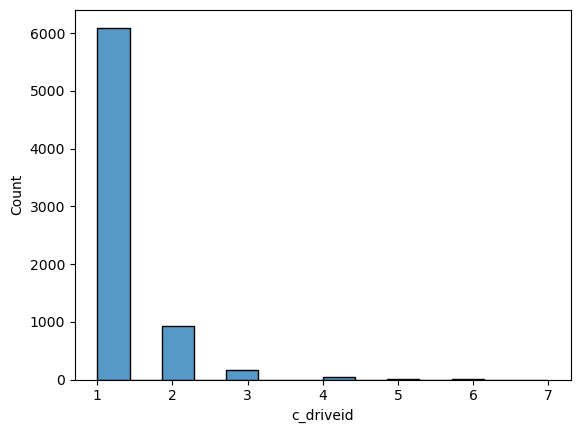

In [47]:
sns.histplot(data.groupby(['c_van17'])['c_driveid'].nunique())

In [53]:
data

,c_van17,c_driveid,c_drive_timestamp_start,c_drive_timestamp_stop,c_msg_creation_timestamp,c_target_temp,c_blower_combined,c_air_mode_combined,c_blower_level,c_min_diff_ms_blower_level,...,c_bcbehvenergystart_kwh,c_bcbehvenergyend_kwh,c_drive_number_per_car,c_number_of_drives_per_car,c_gcad,c_is_active_profile,c_is_guest_profile,c_touchscreen_used,c_touchscreen_used_count,c_first_last_mode
0,AAP07xxNHeSy6vCyuqxAyPQ0Ix0dqWbYgeZ4PoknFoJ4J0...,KXHJ2AJMZFQLPU0PC,2021-03-12 09:49:05.204,2021-03-12 11:11:30.192,2021-03-12 09:49:05.653,19.0,KS_1,AUTO,BL_1,41311.0,...,NaN,NaN,26,43,ACTIVE_PROFILE,True,False,True,24,AUTO -> AUTO
1,AAP07xxNHeSy6vCyuqxAyPQ0Ix0dqWbYgeZ4PoknFoJ4J0...,KXHJ2AJMZFQLPU0PC,2021-03-12 09:49:05.204,2021-03-12 11:11:30.192,2021-03-12 09:49:05.654,20.0,KS_1,AUTO,BL_1,41311.0,...,NaN,NaN,26,43,ACTIVE_PROFILE,True,False,True,24,AUTO -> AUTO
2,AAP07xxNHeSy6vCyuqxAyPQ0Ix0dqWbYgeZ4PoknFoJ4J0...,KXHJ2AJMZFQLPU0PC,2021-03-12 09:49:05.204,2021-03-12 11:11:30.192,2021-03-12 10:01:56.622,20.0,KS_1,OFF,Off,41311.0,...,NaN,NaN,26,43,ACTIVE_PROFILE,True,False,True,24,AUTO -> AUTO
3,AAP07xxNHeSy6vCyuqxAyPQ0Ix0dqWbYgeZ4PoknFoJ4J0...,KXHJ2AJMZFQLPU0PC,2021-03-12 09:49:05.204,2021-03-12 11:11:30.192,2021-03-12 10:11:50.182,20.0,KS_1,AUTO,BL_1,41311.0,...,NaN,NaN,26,43,ACTIVE_PROFILE,True,False,True,24,AUTO -> AUTO
4,AAP07xxNHeSy6vCyuqxAyPQ0Ix0dqWbYgeZ4PoknFoJ4J0...,KXHJ2AJMZFQLPU0PC,2021-03-12 09:49:05.204,2021-03-12 11:11:30.192,2021-03-12 10:14:53.397,18.0,KS_1,AUTO,BL_1,41311.0,...,NaN,NaN,26,43,ACTIVE_PROFILE,True,False,True,24,AUTO -> AUTO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154615,AAKENr+OGltASUqdgfofUlWzmRzQ0ij6V2guPDR3BjzaPd...,55DKM59GRVQ40AALV,2021-05-09 01:39:39.868,2021-05-09 03:26:19.551,2021-05-09 03:19:31.754,16.0,KS_1,AUTO,BL_1,412.0,...,NaN,NaN,7,10,ACTIVE_PROFILE,True,False,True,266,OFF -> OFF
154616,AAKENr+OGltASUqdgfofUlWzmRzQ0ij6V2guPDR3BjzaPd...,55DKM59GRVQ40AALV,2021-05-09 01:39:39.868,2021-05-09 03:26:19.551,2021-05-09 03:25:59.403,16.0,KS_1,OFF,Off,412.0,...,NaN,NaN,7,10,ACTIVE_PROFILE,True,False,True,266,OFF -> OFF
154617,AAKENr+OGltASUqdgfofUlWzmRzQ0ij6V2guPDR3BjzaPd...,55DKM59GRVQ40AALV,2021-05-09 01:39:39.868,2021-05-09 03:26:19.551,2021-05-09 03:26:02.478,16.0,KS_1,OFF,Off,412.0,...,NaN,NaN,7,10,ACTIVE_PROFILE,True,False,True,266,OFF -> OFF
154618,AAKENr+OGltASUqdgfofUlWzmRzQ0ij6V2guPDR3BjzaPd...,55DKM59GRVQ40AALV,2021-05-09 01:39:39.868,2021-05-09 03:26:19.551,2021-05-09 03:26:12.585,16.0,KS_1,OFF,Off,412.0,...,NaN,NaN,7,10,ACTIVE_PROFILE,True,False,True,266,OFF -> OFF


In [52]:
data['c_pwf_group'].unique()

array(['FAHREN', 'WOHNEN', 'STAFKT_KUNDE_NICHT_IM_FZG', 'PARKEN_BN_IO'],
      dtype=object)

In [50]:
data['c_pwf_group']

0                            FAHREN
1                            FAHREN
2                            WOHNEN
3                            FAHREN
4                            FAHREN
                    ...            
154615                       FAHREN
154616                       WOHNEN
154617    STAFKT_KUNDE_NICHT_IM_FZG
154618                       WOHNEN
154619    STAFKT_KUNDE_NICHT_IM_FZG
Name: c_pwf_group, Length: 154620, dtype: object

In [28]:
(data.groupby(['c_van17'])['c_driveid'].nunique() > 10).sum()

38719

In [99]:
data['c_van17'].value_counts().sum()

149438

In [72]:
data.groupby(['c_van17', 'c_driveid']).value_counts()

c_van17                                                                                                               c_driveid          c_drive_timestamp_start  c_drive_timestamp_stop   c_msg_creation_timestamp  c_target_temp  c_blower_combined  c_air_mode_combined  c_blower_level  c_min_diff_ms_blower_level  c_blower_style  c_min_diff_ms_blower_style  c_air_dist  c_min_diff_ms_air_dist  c_auto_mode  c_min_diff_ms_auto_mode  c_pwf                        c_pwf_group                c_row_number_drive  c_number_of_rows_drive  c_only_driving_duration_sec  c_event_duration_sec  c_min_diff_ms_target_temp  c_min_exteriortemperature_celsius  c_exteriortemperature_avg_celsius  c_max_exteriortemperature_celsius  c_interiortemperature_startup_celsius  c_drive_duration_sec  c_drive_duration_minutes  c_drive_weekday  c_year_month_day  c_weekofyear_year  c_weekend_drive  c_vehicle_live_time_days  c_avg_drives_per_day  c_avg_drives_per_week  c_avg_drives_per_month  c_timezonedelta  c_gpsregion_city_

In [89]:
data.groupby('c_van17')['c_driveid'].nunique().min()

11

In [92]:
(data['c_driveid'].value_counts() >= 15).sum()

5975

In [93]:
data['c_driveid'].nunique()

92639

In [94]:
data.head()

,c_van17,c_driveid,c_drive_timestamp_start,c_drive_timestamp_stop,c_msg_creation_timestamp,c_target_temp,c_blower_combined,c_air_mode_combined,c_blower_level,c_min_diff_ms_blower_level,...,c_bcbehvenergystart_kwh,c_bcbehvenergyend_kwh,c_drive_number_per_car,c_number_of_drives_per_car,c_gcad,c_is_active_profile,c_is_guest_profile,c_touchscreen_used,c_touchscreen_used_count,c_first_last_mode
0,AAIV3AxWGa6mQm3+uQqfruzXnpRxIWfVbLIj13+3yA/2Vh...,1H03S92B4JQUYZ4ZM,2021-11-23 00:49:30.163,2021-11-23 01:09:15.266,2021-11-23 00:49:30.243,24.0,KS_3,AUTO,BL_3,12972.0,...,0.0,0.0,2,136,GUEST_PROFILE,False,True,True,3,AUTO -> OFF
1,AAIV3AxWGa6mQm3+uQqfruzXnpRxIWfVbLIj13+3yA/2Vh...,1H03S92B4JQUYZ4ZM,2021-11-23 00:49:30.163,2021-11-23 01:09:15.266,2021-11-23 00:49:43.218,24.0,BL_7,DEFROST,BL_7,12972.0,...,0.0,0.0,2,136,GUEST_PROFILE,False,True,True,3,AUTO -> OFF
2,AAIV3AxWGa6mQm3+uQqfruzXnpRxIWfVbLIj13+3yA/2Vh...,1H03S92B4JQUYZ4ZM,2021-11-23 00:49:30.163,2021-11-23 01:09:15.266,2021-11-23 00:59:10.673,24.0,Off,OFF,Off,12972.0,...,0.0,0.0,2,136,GUEST_PROFILE,False,True,True,3,AUTO -> OFF
3,AAIV3AxWGa6mQm3+uQqfruzXnpRxIWfVbLIj13+3yA/2Vh...,1H03S92B4JQUYZ4ZM,2021-11-23 00:49:30.163,2021-11-23 01:09:15.266,2021-11-23 01:09:13.818,24.0,Off,OFF,Off,12972.0,...,0.0,0.0,2,136,GUEST_PROFILE,False,True,True,3,AUTO -> OFF
4,AAMFtH5OQh6+FDUChi1kEUqSXxEejYT++kHAhmvMJU1UDK...,08L83G8RB4Q3ALMCC,2021-09-30 13:22:31.909,2021-09-30 14:03:08.853,2021-09-30 13:22:32.075,21.0,Off,OFF,Off,27462.0,...,58.0,55.0,5,17,NOT VALID GCAD,False,False,True,1,OFF -> OFF


In [82]:
(data['c_driveid'].value_counts() >= 15).sum()

5975

In [86]:
data['c_van17'].value_counts().min(), data['c_van17'].value_counts().max(), data['c_van17'].value_counts().mean()

(47, 342, 129.546918025842)

In [87]:
# How many drivs per car now?
data.groupby(['c_van17'])['c_driveid'].count().max(), data.groupby(['c_van17'])['c_driveid'].count().min(), data.groupby(['c_van17'])['c_driveid'].count().mean()

(342, 47, 129.546918025842)

In [55]:
id_of_the_max_drives = data['c_van17'].value_counts().idxmax()

In [61]:
data[data['c_van17'] == id_of_the_max_drives]['c_driveid'].nunique()

2

### BERT

In [12]:
df = pd.read_csv('https://gist.githubusercontent.com/Mukilan-Krishnakumar/e998ecf27d11b84fe6225db11c239bc6/raw/74dbac2b992235e555df9a0a4e4d7271680e7e45/imdb_movie_reviews.csv')
df = df.drop('sentiment',axis=1)


In [13]:
from transformers import BertForPreTraining
from transformers import BertModel

In [14]:
model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name)

In [16]:
import torch
a = torch.randint(128, (2, 128))
# a = a.view(-1)
a.shape

torch.Size([2, 128])

In [18]:
last_hidden_states = model(a)['last_hidden_state']
last_hidden_states.shape

torch.Size([2, 128, 768])

In [150]:
last_hidden_states = last_hidden_states.reshape(-1, 768)

In [151]:
# For example, linear classifier to 10 classes
classifier = torch.nn.Linear(last_hidden_states.shape[1], 768)
logits = classifier(last_hidden_states)

In [152]:
logits.shape

torch.Size([256, 768])

In [ ]:
model = BertForPreTraining.from_pretrained

In [20]:
import torch
import pandas as pd
import numpy as n
from transformers import BertTokenizer, BertForSequenceClassification


In [21]:
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [ ]:
text = "The person drives a BMW car "

In [22]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [25]:
df['text'][0]

'My daughter liked it but I was aghast, that a character in this movie smokes. As if it isn\'t awful enough to see "product placement" actors like Bruce Willis who smoke in their movies - at least children movies should be more considerate! I wonder: was that intentional? Did big tobacco "sponsor" the film? What does it take to ban smoking from films? At least films intended for children and adolescents. My daughter liked it but I was aghast, that a character in this movie smokes. As if it isn\'t awful enough to see "product placement" actors like Bruce Willis who smoke in their movies - at least children movies should be more considerate! I wonder: was that intentional? Did big tobacco "sponsor" the film? What does it take to ban smoking from films? At least films intended for children and adolescents.'

In [28]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [26]:
def sentiment_movie_score(movie_review):
    print(f"movie review: {movie_review}")
    token = tokenizer.encode(movie_review, return_tensors = 'pt')
    print(token.shape)
    result = model(token)
    return int(torch.argmax(result.logits))+1
df['sentiment'] = df['text'].apply(lambda x: sentiment_movie_score(x[:512]))


movie review: My daughter liked it but I was aghast, that a character in this movie smokes. As if it isn't awful enough to see "product placement" actors like Bruce Willis who smoke in their movies - at least children movies should be more considerate! I wonder: was that intentional? Did big tobacco "sponsor" the film? What does it take to ban smoking from films? At least films intended for children and adolescents. My daughter liked it but I was aghast, that a character in this movie smokes. As if it isn't awful enough 
torch.Size([1, 125])
movie review: I... No words. No words can describe this. I will try for the sake of those few brave people who stick knives into their toasters... after watching this show.<br /><br />This... Cosgrove person... Her acting is like watching a female gorilla dance upon the nest of highly agitated insects. Perhaps I exaggerate. However, I have a feeling that the description fits a regular day of writing this show.<br /><br />The characters in this repu

In [ ]:
df['sentiment']

0      3
1      1
2      2
3      1
4      4
      ..
130    1
131    4
132    4
133    5
134    4
Name: sentiment, Length: 135, dtype: int64

In [ ]:
df.iloc[1]['text']

"I... No words. No words can describe this. I will try for the sake of those few brave people who stick knives into their toasters... after watching this show.<br /><br />This... Cosgrove person... Her acting is like watching a female gorilla dance upon the nest of highly agitated insects. Perhaps I exaggerate. However, I have a feeling that the description fits a regular day of writing this show.<br /><br />The characters in this repulsive pile of raw sewage are as useless as a small piece of space rock that flies into the sun on any day of the week. Though heart attacks have not been experienced while watching them act like fools on the cheaply built sets, I have no doubt that it will happen eventually.<br /><br />The main plot of this *belches loudly into the faces of the actors* is that of a foolish girl who hosts a live weekly web-cast on the creatively titled iCarly.com with her brainless friends, one of which owns equipment that the producers of this show probably couldn't affor

In [ ]:
test_traj_path = "../data/smart-climate-2021/datasets_with_non_filled_events/train-test-sets/smart-climate-test-trajectories-v1-wo-prev-target-temp.pkl" 

with open(test_traj_path, 'rb') as f:
    self.dataset = pickle.load(f)